({'x': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 2048) dtype=float32>}, <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?,) dtype=int32>)
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2b4484eaaeb8>, '_log_step_count_steps': 100, '_save_checkpoints_steps': 100, '_task_id': 0, '_task_type': None, '_is_chief': True, '_save_checkpoints_secs': None, '_num_worker_replicas': 0, '_evaluation_master': '', '_model_dir': '/tmp/tf_lin', '_tf_random_seed': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
log_device_placement: true
, '_save_summary_steps': 10, '_environment': 'local', '_session_config': None, '_master': '', '_num_ps_replicas': 0}
INFO:tensorflow:Calling model_fn.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
================ logit:  train (?, 2)
================ loss:  train ()
INFO:tens

INFO:tensorflow:global_step/sec: 8.57292
INFO:tensorflow:loss = 0.03761205, step = 584 (11.665 sec)
INFO:tensorflow:Saving checkpoints for 644 into /tmp/tf_lin/model.ckpt.
INFO:tensorflow:Loss for final step: 0.012903039.
INFO:tensorflow:Calling model_fn.
================ logit:  eval (?, 2)
================ loss:  eval ()
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-12-18:08:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_lin/model.ckpt-644
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-12-18:08:04
INFO:tensorflow:Saving dict for global step 644: accuracy = 1.0, global_step = 644, loss = 0.016793445
{'accuracy': 1.0, 'loss': 0.016793445, 'global_step': 644}
[0.6925904, 0.68852705, 0.50960654, 0.016793445]
[0.5147929, 0.57100594, 0.9674556, 1.0]


SystemExit: 

/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


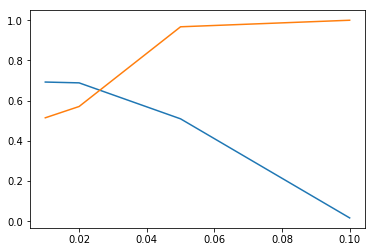

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

N_DIGITS = 2
X_FEATURE = 'x'  # Name of the input feature.

RATE=2048
BATCH = 128
gloss=[]
gacc=[]

####
####   Network architecture
####   [N,RATE]  -->  [N,RATE,1]
def conv_model(features, labels, mode):
  feature = tf.reshape(features[X_FEATURE], [-1, RATE,1])
  with tf.variable_scope('conv_layer1'):
    h_conv1 = tf.layers.conv1d(feature, filters=16, kernel_size=[16], padding='same', activation=tf.nn.relu)
    h_pool1 = tf.layers.max_pooling1d(h_conv1, pool_size=4, strides=4, padding='same', name='p1')
  with tf.variable_scope('conv_layer2'):
    h_conv2 = tf.layers.conv1d(h_pool1, filters=32, kernel_size=[8], padding='same', activation=tf.nn.relu)
    h_pool2 = tf.layers.max_pooling1d(h_conv2, pool_size=4, strides=4, padding='same', name='p2')
    ##h_pool2 = tf.layers.batch_normalization(h_pool2n)
  with tf.variable_scope('conv_layer3'):
    h_conv3 = tf.layers.conv1d(h_pool2, filters=64, kernel_size=[8], padding='same', activation=tf.nn.relu)
    h_pool3 = tf.layers.max_pooling1d(h_conv3, pool_size=4, strides=4, padding='same', name='p3')
    
    dim = h_pool3.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    h_pool3_flat = tf.reshape(h_pool3, [-1, fcnn])   ## linearize the matrix into 1D vector, =64*119
    #print ("================ P3F: ", mode, h_pool3_flat.get_shape())

  # Densely connected layer
  h_fc1 = tf.layers.dense(h_pool3_flat, 64, activation=tf.nn.relu, name='d1')
  ### if mode == tf.estimator.ModeKeys.TRAIN: h_fc1 = tf.layers.dropout(h_fc1, rate=0.5)   ## dropout not used by Huerta

  ### 2-output   [BATCH,2]
  logits = tf.layers.dense(h_fc1, N_DIGITS, activation=None, name='d2')   ## No activation
  print ("================ logit: ", mode, logits.get_shape() )

  # Compute predictions
  predict_op =  tf.argmax(input=logits, axis=1)   ## return largest index

  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        'class': predict_op,
        'prob': tf.nn.softmax(logits, name="softmax_tensor")
    }
    return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Create training op.
  loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels)
  print ("================ loss: ", mode, loss.get_shape())

  summary_hook = tf.train.SummarySaverHook(2, output_dir='/tmp/tf_lin/summary', 
                                           summary_op=tf.summary.merge_all())

  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    train_op  = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op, training_hooks=[summary_hook])

  # Compute evaluation metrics.
  eval_metric_ops = {
      'accuracy': tf.metrics.accuracy(labels=labels, predictions=predict_op )
  }
  return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=eval_metric_ops, training_hooks=[summary_hook])

def prepare_data(SNR):
  N=1024
  N0=N//2
  L0=10  
  coor=np.linspace(0,L0,RATE)  
  X      = np.random.rand(N,RATE) - 0.5
  X[:N0] = X[:N0] + SNR*np.sin(2*np.pi*coor*((np.random.rand()+0.5)*2)/L0 )
  X      = X.astype(np.float32)
  y      = np.zeros(N)
  y[:N0] = np.ones(N0)
  y      = y.astype(np.int32)
  return train_test_split(X, y, test_size=0.33, random_state=42) 
        
    
def CNN(SNR):
    tf.logging.set_verbosity(tf.logging.INFO)
    #tf.logging.set_verbosity(tf.logging.WARN)
    
    X_train, X_test, y_train, y_test = prepare_data(SNR)
    ### Download and load MNIST dataset.##mnist = tf.contrib.learn.datasets.DATASETS['mnist']('/tmp/mnist')
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = { X_FEATURE: X_train },  y = y_train,
        batch_size = BATCH,### step = N * epoches / Batch 
        num_epochs = 30,  shuffle=True)
    test_input_fn = tf.estimator.inputs.numpy_input_fn(
        x= { X_FEATURE: X_test },   y= y_test,
        #batch_size = None,
        num_epochs=1,   shuffle=False)

    print (test_input_fn())
    
    
    config = tf.contrib.learn.RunConfig(
        log_device_placement=True,
        save_checkpoints_steps=100,
        save_checkpoints_secs=None,
        save_summary_steps=10,
        gpu_memory_fraction=1,
    )
    
    
    classifier = tf.estimator.Estimator(model_fn=conv_model, config=config, model_dir='/tmp/tf_lin')
    classifier.train(input_fn=train_input_fn, steps=None)
    scores = classifier.evaluate(input_fn=test_input_fn, steps=None)
    
    ####  Turn-on to see the result of prediction======================
    PREDICTION = False
    if PREDICTION:
      prediction = classifier.predict(input_fn = test_input_fn)
      for p in prediction:  print (p)
    ###################################
    
    print(scores)  
    return scores['loss'],scores['accuracy']

    if 0:      ######### Linear classifier.
        feature_columns = [ tf.feature_column.numeric_column(X_FEATURE, shape=RATE) ]

        classifier = tf.estimator.LinearClassifier(feature_columns = feature_columns, n_classes=N_DIGITS)
        classifier.train(input_fn=train_input_fn, steps=None)
        scores = classifier.evaluate(input_fn=test_input_fn, steps=None)
        print("+++++ LC: ", scores)


def main(unused):
    
    ########## CNN
    try: os.remove('/tmp/tf_lin/checkpoint')  
    except OSError: pass

    snr = [0.01, 0.02, 0.05, 0.1]
    #snr = [0.03]
    for x in snr:
        l, a = CNN(x)
        gloss.append(l)
        gacc.append(a)
    print(gloss)
    print(gacc)
    plt.plot(snr,gloss)
    plt.plot(snr,gacc)
        
import os
if __name__ == '__main__':
  tf.app.run()
  print("End-----------------")
    
  os._exit(0)

In [29]:
import numpy as np
import tensorflow as tf

DIM=4096
N=10000

X=np.random.rand(DIM,N)

np.random.shuffle(X[2])
print (X)


[[ 0  1  2  3  4  5  6  7  8  9]
 [ 1  2  3  4  5  6  7  8  9 10]
 [ 6  2  3  7  5  4 10  8 11  9]]


In [134]:
session = tf.get_default_session()
tf.one_hot([0,1,2], 2).eval(session=sess)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.]], dtype=float32)